import the needed packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils.utils import shapley_values

prepare the dataset

In [13]:
telecom = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
# deal with binary features
bin_features = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
telecom[bin_features] = telecom[bin_features].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

telecom['gender'] = telecom['gender'].map({'Male': 1, 'Female': 0})

In [15]:
# deal with multinominal features by using dummy features

dummy = pd.get_dummies(telecom[['Contract', 'PaymentMethod', 'InternetService']], drop_first=True)
telecom = pd.concat([telecom, dummy], axis=1)

# deal with the rest by hand by droping all the No phone/internet service
# MultipleLines
ml = pd.get_dummies(telecom['MultipleLines'], prefix='MultipleLines')
ml = ml.drop('MultipleLines_No phone service', axis=1)
telecom = pd.concat([telecom, ml], axis=1)

# OnlineSecurity
os = pd.get_dummies(telecom['OnlineSecurity'], prefix='OnlineSecurity')
os = os.drop('OnlineSecurity_No internet service', axis=1)
telecom = pd.concat([telecom, os], axis=1)

# OnlineBackup
ob = pd.get_dummies(telecom['OnlineBackup'], prefix='OnlineBackup')
ob = ob.drop('OnlineBackup_No internet service', axis=1)
telecom = pd.concat([telecom, ob], axis=1)

# DeviceProtection
dp = pd.get_dummies(telecom['DeviceProtection'], prefix='DeviceProtection')
dp = dp.drop(['DeviceProtection_No internet service'], axis=1)
telecom = pd.concat([telecom, dp], axis=1)

# TechSupport
ts = pd.get_dummies(telecom['TechSupport'], prefix='TechSupport')
ts = ts.drop(['TechSupport_No internet service'], axis=1)
telecom = pd.concat([telecom, ts], axis=1)

# StreamingTV
st =pd.get_dummies(telecom['StreamingTV'], prefix='StreamingTV')
st = st.drop(['StreamingTV_No internet service'], axis=1)
# Adding the results to the telecom dataframe
telecom = pd.concat([telecom, st], axis=1)


# MultipleLines
sm = pd.get_dummies(telecom['StreamingMovies'], prefix='StreamingMovies')
sm = sm.drop(['StreamingMovies_No internet service'], axis=1)
telecom = pd.concat([telecom, sm], axis=1)

telecom.head()

# drop the repeated features after creating dummies
telecom = telecom.drop(['Contract', 'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity',
 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)

telecom['TotalCharges'] = pd.to_numeric(telecom["TotalCharges"].replace(" ",""),downcast="float")

telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   gender                                 7043 non-null   int64  
 2   SeniorCitizen                          7043 non-null   int64  
 3   Partner                                7043 non-null   int64  
 4   Dependents                             7043 non-null   int64  
 5   tenure                                 7043 non-null   int64  
 6   PhoneService                           7043 non-null   int64  
 7   PaperlessBilling                       7043 non-null   int64  
 8   MonthlyCharges                         7043 non-null   float64
 9   TotalCharges                           7032 non-null   float32
 10  Churn                                  7043 non-null   int64  
 11  Cont

In [16]:
# check for null features data

telecom.isnull().sum()
# there are 11 data points with null feature TotalCharges
telecom = telecom[~np.isnan(telecom['TotalCharges'])]

Split the dataset

In [17]:
X = telecom.drop(['Churn', 'customerID'], axis=1)
y = telecom['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=110810)
# scale the continuous features
scaler = StandardScaler()
scaler.fit(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])

X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_One year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
1044,0,0,0,0,-0.989049,1,0,-0.352842,-0.806349,1,...,1,0,1,0,0,1,1,0,1,0
3116,0,1,0,0,0.469922,1,0,0.808778,0.747970,1,...,0,1,0,1,1,0,1,0,0,1
4854,1,0,1,1,-0.583779,0,0,-0.614123,-0.646376,1,...,0,1,0,1,1,0,0,1,1,0
5775,1,0,1,1,1.037299,1,0,0.587438,1.115295,0,...,1,0,1,0,1,0,0,1,1,0
4552,0,0,0,0,-0.948522,1,1,-1.477849,-0.938047,0,...,0,0,0,0,0,0,0,0,0,0


Start building models

In [18]:
# first model using all the features
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(log_loss(y_test, y_predict))

0.8151658767772512
6.383998642866202


In [19]:
# second model uses PCA to get more important variables

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(pca.explained_variance_ratio_)
LRPCA = LogisticRegression(max_iter=1000)
LRPCA.fit(X_train, y_train)
y_predict = LRPCA.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(log_loss(y_test, y_predict))

[0.3278794  0.17584024 0.05913382 0.04541409 0.03650049 0.03466057
 0.03283038 0.0316507  0.03041093 0.02815268]
0.8099526066350711
6.564054446075816


Now we will try to figure out what kind of data is more important to the classifier

[[1.3832294 ]
 [0.96971505]
 [1.01301519]
 [1.31708115]
 [1.56958033]
 [2.06462884]
 [0.10733068]
 [0.01280107]
 [1.96983294]
 [0.17002787]
 [0.50260665]
 [0.96065399]
 [0.61069034]
 [2.35651611]
 [1.46501268]
 [0.21488315]
 [1.78275295]
 [3.06080855]
 [0.93965934]
 [2.43493683]
 [2.64283769]
 [0.28132861]
 [2.26405779]
 [2.5954966 ]
 [2.28077546]
 [0.08018074]
 [1.57188287]
 [2.27769882]
 [0.78924882]
 [3.48666694]
 [1.38475592]
 [1.61250008]
 [2.80472077]
 [0.666315  ]
 [0.4219581 ]
 [1.88770478]
 [0.07354722]
 [0.51602978]
 [1.18813253]
 [0.43839543]
 [1.22698482]
 [1.13391859]
 [1.2807509 ]
 [1.81944754]
 [0.70450958]
 [1.09643602]
 [0.42760817]
 [0.59854945]
 [3.46981903]
 [0.53089353]
 [0.61079077]
 [0.24274134]
 [2.77096224]
 [0.28816467]
 [1.09704977]
 [0.59367098]
 [2.06830844]
 [1.62948077]
 [2.00411   ]
 [0.90644959]
 [1.40342922]
 [0.03306344]
 [2.58242298]
 [1.09461251]
 [1.12269497]
 [1.56300239]
 [2.04036217]
 [0.52285157]
 [1.33164269]
 [1.89406077]
 [1.15092813]
 [0.43

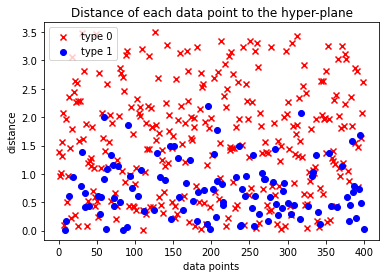

In [20]:
w = LRPCA.coef_
b = LRPCA.intercept_

num = 400

idx = np.arange(1, len(X_train) + 1)[:num]

dist = np.array([abs(np.dot(w, X_train[i]) + b) for i in range(num)])
dist /= np.linalg.norm(w)
print(dist)
s0 = plt.scatter(idx[y_train[:num]==0], dist[y_train[:num]==0], c='r', marker='x')
s1 = plt.scatter(idx[y_train[:num]==1], dist[y_train[:num]==1], c='b', marker='o')
plt.xlabel('data points')
plt.ylabel('distance')
plt.title('Distance of each data point to the hyper-plane')
plt.legend(handles=[s0, s1], labels=['type 0', 'type 1'])
plt.show()

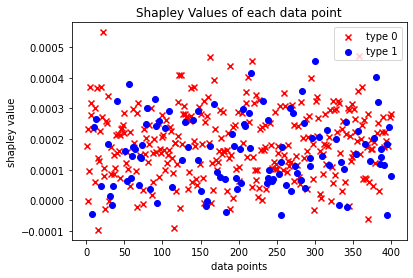

In [21]:
# under the pca data, do compute the SV for all the data points needs about 2 days, 
# so this can only be done on less data points, or turn to data groups
num = 400
svs = shapley_values(X_train[:num], y_train[:num], X_test, y_test)

idx = np.arange(1, len(X_train) + 1)[:num]
s0 = plt.scatter(idx[y_train[:num]==0], svs[y_train[:num]==0], c='r', marker='x')
s1 = plt.scatter(idx[y_train[:num]==1], svs[y_train[:num]==1], c='b', marker='o')
plt.xlabel('data points')
plt.ylabel('shapley value')
plt.title('Shapley Values of each data point')
plt.legend(handles=[s0, s1], labels=['type 0', 'type 1'])
plt.show()